# <center> [INDICIUM] - Processo Seletivo - Lighthouse Programa de Formação em Dados (Remoto) </center>
    
# <center> Treino e Teste do Modelo</center>

### Objetivo: Identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura. ###

Como o tipo de rótulo é um dado discreto o tipo de modelo a ser utilzado será a classificação. Ao longo deste notebook serão descritas as etapas necessárias para atingir o objetivo.

In [1]:
#Import das libs necessárias no projeto
import pandas as pd
import seaborn as sn
import numpy as np

import matplotlib.pyplot as plt


#bliblotecas para a preparação do modelo
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

#import o classificador 
import lightgbm as lgb

from xgboost import XGBClassifier

from sklearn import svm

#import label encoder
from sklearn import preprocessing

from sklearn.multioutput import MultiOutputClassifier

from numpy import argmax 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


from pandasql import sqldf

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

from collections import Counter

from imblearn.datasets import make_imbalance


In [2]:
#Ler os dados do csv e transformar em um dataframe para possibilitar a sua manipulação
df_treino = pd.read_csv("./desafio_manutencao_preditiva_treino.csv")
df_teste = pd.read_csv("./desafio_manutencao_preditiva_teste.csv")

In [3]:
print("Shape train: %s, test: %s" % (df_treino.shape, df_teste.shape))

Shape train: (6667, 9), test: (3333, 8)


In [4]:
#Visualizar as cinco primeiras linhas do dataset de treino
df_treino.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


Como a análise explorartória tinha demonstrado não há dados nulos nas colunas, assim não é necessário nemhuma técnica de tratamento de dados faltantes.

In [5]:
print(df_treino.isnull().sum())

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64


## Parte 1 - Transformação e Preprocessamento dos dados

Passo 1: Criar outro dataframe com base no original para poder manipular os dados.

Importante: Só serão copiados as colunas relevantes para o processo de transformação e treino do modelo. 

As colunas product_id e type não foram consideradas para análise.

In [6]:
df_treino_tf = df_treino[["air_temperature_k", "process_temperature_k", "rotational_speed_rpm", "torque_nm", "tool_wear_min", "failure_type"]].copy()

In [7]:
#o novo dataframe de treino criado
df_treino_tf.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.2,308.7,1408,40.0,9,No Failure
3,298.1,308.6,1425,41.9,11,No Failure
4,298.1,308.6,1558,42.4,14,No Failure


In [8]:
df_teste_tf = df_teste[["air_temperature_k", "process_temperature_k", "rotational_speed_rpm", "torque_nm", "tool_wear_min"]].copy()

In [9]:
df_teste_tf.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,297.5,308.6,1793,26.7,70
1,300.7,310.5,1536,47.4,192
2,297.2,308.4,1460,42.1,41
3,299.4,309.1,1670,35.9,68
4,304.1,313.1,1550,30.9,9


Passo 2: Contar a quantidade por classe na coluna failure_type. Para atingir o problema essa coluna servirá como rótulos a serem inseridos no modelo. 


In [10]:
df_treino_tf["failure_type"].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

Passo 3: Transformar a variável failure_type que é categórica em uma variável númerica. Os nomes serão transformados em números.

In [11]:
#transformar o y  
#make an instance of Label Encoder
label_encoder = preprocessing.LabelEncoder()

#transformando os dados de treino
df_treino_tf["failure_type"] = label_encoder.fit_transform(df_treino_tf["failure_type"])

In [12]:
df_treino_tf["failure_type"].value_counts()

1    6435
0      75
3      63
2      52
5      30
4      12
Name: failure_type, dtype: int64

In [13]:
#definindo o y para o treino. Será o rótulo do aprendizado
y = df_treino_tf["failure_type"]
y.sample(3)

6059    1
5397    1
852     1
Name: failure_type, dtype: int64

In [14]:
#retirando o y do conjunto de treino e as colunas que não seram utilizadas durante o processo de treinamento
df_treino_tf.drop(["failure_type"], axis=1, inplace=True)

In [15]:
df_treino_tf.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.2,308.7,1408,40.0,9
3,298.1,308.6,1425,41.9,11
4,298.1,308.6,1558,42.4,14


Passo 4: Reescala dos dados

Ao análisar os dados que serão considerados para análise percebe-se que os dados estão em escalas diferentes. 

Será utilizado uma técnica chamada StandardScaler. O cálculo da reescala é feito de forma independente entre cada coluna, de tal forma que a nova escala se dará entre 0 e 1 (ou -1 e 1 se houver valores negativos no dataset). O valor é diminuido da média e divido pelo desvio padrão.

valor = (valor — média) / desvioPadão

In [16]:
df_treino_nor = df_treino_tf.copy()
df_treino_nor[['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']] = StandardScaler().fit_transform(df_treino_tf[['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']])

In [17]:
df_treino_nor

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,-0.948838,-0.935907,0.076652,0.275525,-1.706224
1,-0.898702,-0.868702,-0.730484,0.627282,-1.658872
2,-0.898702,-0.868702,-0.730484,-0.005881,-1.564168
3,-0.948838,-0.935907,-0.634531,0.185073,-1.532600
4,-0.948838,-0.935907,0.116163,0.235324,-1.485247
...,...,...,...,...,...
6662,-0.597884,-1.137521,0.545130,-1.221954,-1.516816
6663,-0.597884,-1.070317,0.375801,-1.061151,-1.485247
6664,-0.547747,-1.070317,0.533841,-0.829996,-1.437895
6665,-0.497611,-0.868702,-0.730484,0.848386,-1.311623


Para manter o dataset de teste na mesma escala que o dataset de treino, também será utilizado StandardScaler.

In [18]:
df_teste_nor = df_teste_tf.copy()
df_teste_nor[['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']] = StandardScaler().fit_transform(df_teste_tf[['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']])

In [19]:
df_teste_nor

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,-1.257913,-0.970720,1.371494,-1.313901,-0.586211
1,0.333272,0.317747,-0.029935,0.755363,1.312989
2,-1.407086,-1.106348,-0.444366,0.225551,-1.037660
3,-0.313147,-0.631650,0.700771,-0.394228,-0.617345
4,2.023906,2.080913,0.046407,-0.894050,-1.535811
...,...,...,...,...,...
3328,1.228314,1.267144,-1.284133,1.984926,1.001645
3329,0.333272,0.656818,-0.700658,1.215199,-0.259299
3330,0.382997,0.792446,-0.329852,-0.134321,1.141750
3331,1.377487,1.470587,-0.177167,-0.334250,-0.866421


## Parte 2 - Construção e treino dos modelos

O objetivo dessa parte é testar qual o melhor modelo de dados a ser utilizado. Se deixa o modelo multiclass, com os rótulos originais do banco de dados, ou se agrupa todos os tipos de falhas em uma única coluna Failure.

In [20]:
X_teste_df = df_teste_nor.to_numpy()

In [21]:
X_teste_df

array([[-1.25791266, -0.97071985,  1.37149439, -1.31390115, -0.58621105],
       [ 0.33327219,  0.31774747, -0.02993524,  0.75536292,  1.31298946],
       [-1.40708624, -1.10634799, -0.44436579,  0.22555135, -1.03766036],
       ...,
       [ 0.38299671,  0.79244596, -0.32985209, -0.13432067,  1.14175007],
       [ 1.37748724,  1.47058665, -0.17716715, -0.33424956, -0.86642097],
       [ 0.03492503, -0.56383543,  0.79347283, -1.2139367 , -0.19703062]])

In [22]:
#definindo o conjunto de treino
X_train, X_test, y_train, y_test = train_test_split(df_treino_nor, y, test_size=0.2, random_state=42)

### 1. Teste I - Sem balanceamento das classes

Nesse teste as classes não serão balanceadas

#### a) Classifier Light Gradient Boosting Machine (LightGBM)

O primeiro classificador a ser testado será o LightGBM. Ele é **Gradient Boosting Framework** que utiliza da lógica de aprendizado por Árvore de Decisão. A vantagem desse classificador em relação aos demais é que a árvore cresce verticalmente, o algoritmo seleciona a "folha que tenha o máximo delta **loss to grow**.

Referência: B. Wang, Y. Wang, K. Qin and Q. Xia, "Detecting Transportation Modes Based on LightGBM Classifier from GPS Trajectory Data," 2018 26th International Conference on Geoinformatics, Kunming, China, 2018, pp. 1-7, doi: 10.1109/GEOINFORMATICS.2018.8557149.


Na análise exploratória dos dados foi detectado que a classe 'No Failure' tem um número expressivamente maior que as demais classes. Esse fator pode dar um problema no processo de classificação tendo em vista que o desbalanceamento entre as classes tende o resultado para classe mais expressiva, como no caso da base de dados é a classe 'No Failure'. Para testar essa hipótese será criado um modelo utilizando o classificador 

In [23]:
#definindo os parâmetros
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_class': 6
} 

In [24]:
# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [25]:
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 5
[LightGBM] [Info] Start training from score -4.438534
[LightGBM] [Info] Start training from score -0.036472
[LightGBM] [Info] Start training from score -4.868097
[LightGBM] [Info] Start training from score -4.630425
[LightGBM] [Info] Start training from score -6.384445
[LightGBM] [Info] Start training from score -5.323573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.117426
[2]	valid_0's multi_logloss: 0.105359
[3]	valid_0

In [26]:
y_pred_lgb = model.predict(X_test)
y_pred_lgb = argmax(y_pred_lgb, axis=1)
cr = classification_report(y_test, y_pred_lgb)
cm = confusion_matrix(y_test, y_pred_lgb)

/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [27]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.99      1.00      0.99      1293
           2       0.78      0.64      0.70        11
           3       0.67      0.55      0.60        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4

    accuracy                           0.98      1334
   macro avg       0.57      0.50      0.53      1334
weighted avg       0.98      0.98      0.98      1334



In [28]:
print(cm) 

[[  10    2    0    0    0    0]
 [   0 1288    1    3    0    1]
 [   0    4    7    0    0    0]
 [   0    4    1    6    0    0]
 [   0    3    0    0    0    0]
 [   0    4    0    0    0    0]]


In [29]:
print("Accuracy score %.3f" % metrics.accuracy_score(y_test, y_pred_lgb))

Accuracy score 0.983


#### b) Classifier SVM

In [30]:
svc = SVC(C=1.0, random_state=1, kernel='linear')
 
# Fit the model
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=1)

In [31]:
y_pred_svm = model.predict(X_test)
y_pred_svm = argmax(y_pred_svm, axis=1)
cr_svm = classification_report(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [32]:
print(cr_svm)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.99      1.00      0.99      1293
           2       0.78      0.64      0.70        11
           3       0.67      0.55      0.60        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4

    accuracy                           0.98      1334
   macro avg       0.57      0.50      0.53      1334
weighted avg       0.98      0.98      0.98      1334



In [33]:
print(cm_svm)

[[  10    2    0    0    0    0]
 [   0 1288    1    3    0    1]
 [   0    4    7    0    0    0]
 [   0    4    1    6    0    0]
 [   0    3    0    0    0    0]
 [   0    4    0    0    0    0]]


In [34]:
# Measure the performance
print("Accuracy score %.3f" % metrics.accuracy_score(y_test, y_pred_svm))

Accuracy score 0.983


### 2. Teste II - Com balanceamento das classes

#### Nesse teste as classes serão balanceadas

Como o conjunto de dados é pequeno, e o número de exemplos da classe 1 (No faiture) é bem expressiva em relação as demais optou-se por utilizar uma técnica de Over-sampling onde será replica os dados já existentes aumentando assim o número de ocorrências das classes minoritárias.  

In [35]:
#O número foi determinado com base no número classe com maior número de exemplos
strategy = {0:5142, 1:5142, 2:5142, 3:5142, 4:5142, 5:5142}
oversample = SMOTE(sampling_strategy=strategy)
X_train_im, y_train_im = oversample.fit_resample(X_train, y_train)

Class=1, n=5142 (16.667%)
Class=5, n=5142 (16.667%)
Class=0, n=5142 (16.667%)
Class=3, n=5142 (16.667%)
Class=2, n=5142 (16.667%)
Class=4, n=5142 (16.667%)


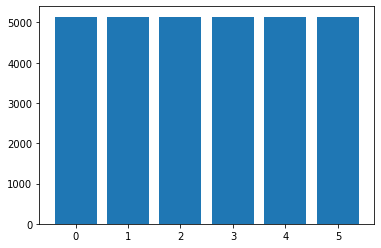

In [36]:
counter = Counter(y_train_im)
for k,v in counter.items():
    per = v / len(y_train_im) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

#### a) Classifier Light Gradient Boosting Machine (LightGBM)

In [37]:
# laoding data
lgb_train_im = lgb.Dataset(X_train_im, y_train_im)
lgb_eval_im = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [38]:
model = lgb.train(params,
                 train_set=lgb_train_im,
                 valid_sets=lgb_eval_im,
                 )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 30852, number of used features: 5
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[1]	valid_0's multi_logloss: 1.49216
[2]	valid_0's multi_logloss: 1.30181
[3]	valid_0's multi_logloss: 1.14571
[4]	valid_0's multi_logloss: 1.0265
[5]	valid_0's multi_logloss: 0.933469
[6]	valid_0's multi_logloss: 0.856209
[7]	valid_0's multi_logloss: 0.794695
[8]	valid_0's multi_logloss: 0.739507
[9]	valid_0's multi_lo

In [39]:
y_pred_lgb_im = model.predict(X_test)
y_pred_lgb_im = argmax(y_pred_lgb_im, axis=1)
cr_im = classification_report(y_test, y_pred_lgb_im)
cm_im = confusion_matrix(y_test, y_pred_lgb_im)

In [40]:
print("Accuracy score %.3f" % metrics.accuracy_score(y_test, y_pred_lgb_im))

Accuracy score 0.960


In [41]:
print(cr_im)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.99      0.97      0.98      1293
           2       0.50      0.73      0.59        11
           3       0.50      0.64      0.56        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4

    accuracy                           0.96      1334
   macro avg       0.50      0.56      0.52      1334
weighted avg       0.98      0.96      0.97      1334



In [42]:
print(cm_im)

[[  12    0    0    0    0    0]
 [   0 1253    7    7   12   14]
 [   0    3    8    0    0    0]
 [   0    3    1    7    0    0]
 [   0    3    0    0    0    0]
 [   0    4    0    0    0    0]]


#### b) Classifier SVM

In [43]:
svc_im = SVC(C=1.0, random_state=1, kernel='linear')
 
# Fit the model
svc_im.fit(X_train_im, y_train_im)

SVC(kernel='linear', random_state=1)

In [44]:
y_pred_svm_im = model.predict(X_test)
y_pred_svm_im = argmax(y_pred_svm_im, axis=1)
cr_svm_im = classification_report(y_test, y_pred_svm_im)
cm_svm_im = confusion_matrix(y_test, y_pred_svm_im)

In [45]:
print(cr_svm_im)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.99      0.97      0.98      1293
           2       0.50      0.73      0.59        11
           3       0.50      0.64      0.56        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4

    accuracy                           0.96      1334
   macro avg       0.50      0.56      0.52      1334
weighted avg       0.98      0.96      0.97      1334



In [46]:
print(cm_svm_im)

[[  12    0    0    0    0    0]
 [   0 1253    7    7   12   14]
 [   0    3    8    0    0    0]
 [   0    3    1    7    0    0]
 [   0    3    0    0    0    0]
 [   0    4    0    0    0    0]]


In [47]:
print("Accuracy score %.3f" % metrics.accuracy_score(y_test, y_pred_svm_im))

Accuracy score 0.960


### 3. Criar o csv do modelo com o melhor resultado

In [48]:
predicted = pd.DataFrame(y_pred_lgb_im, columns=['predictions']).to_csv('predicted.csv')